In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import t
from scipy.stats import probplot


In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 데이터 불러오기

In [3]:
train = pd.read_csv('train_변수명수정결측치0.csv', encoding='cp949')
train.head()

,Unnamed: 0,stn,year,mmddhh,ta,td,hm,ws,rn,re,...,ss,sn,month,day,hour,spring,summer,autumn,winter,season
0,1,1,A,20100,-9.9,-10.7,93.9,0.6,0.0,0.0,...,0.0,0.0,2,1,0,0,0,0,1,4
1,2,1,A,20101,-10.8,-11.6,93.8,0.6,0.0,0.0,...,0.0,0.0,2,1,1,0,0,0,1,4
2,3,1,A,20102,-11.4,-12.1,94.6,0.7,0.0,0.0,...,0.0,0.0,2,1,2,0,0,0,1,4
3,4,1,A,20103,-11.6,-12.5,93.4,0.6,0.0,0.0,...,0.0,0.0,2,1,3,0,0,0,1,4
4,5,1,A,20104,-11.8,-12.7,93.0,0.6,0.0,0.0,...,0.0,0.0,2,1,4,0,0,0,1,4


In [4]:
# 결측 개수 확인
train.isnull().sum()

Unnamed: 0       0
stn              0
year             0
mmddhh           0
ta              63
td              78
hm              17
ws             429
rn            7140
re            1573
ww               0
ts               0
si               0
ss               0
sn               0
month            0
day              0
hour             0
spring           0
summer           0
autumn           0
winter           0
season           0
dtype: int64

In [5]:
train.year.unique()

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object)

#### 변수변환: year(A~F => 2016~2021)

In [6]:
train_copy = train.copy()
train_copy['year_num'] = train_copy.year.apply(lambda x: 2016 if x == 'A' 
                                            else 2017 if x == 'B'
                                            else 2018 if x == 'C'
                                            else 2019 if x == 'D'
                                            else 2020 if x == 'E'
                                            else 2021 if x == 'F'
                                            else x)

In [7]:
train_copy.columns

Index(['Unnamed: 0', 'stn', 'year', 'mmddhh', 'ta', 'td', 'hm', 'ws', 'rn',
       're', 'ww', 'ts', 'si', 'ss', 'sn', 'month', 'day', 'hour', 'spring',
       'summer', 'autumn', 'winter', 'season', 'year_num'],
      dtype='object')

In [8]:
train_copy[['year_num', 'year']].value_counts()

year_num  year
2019      D       87746
2017      B       87498
2020      E       87497
2018      C       87390
2016      A       80043
2021      F        7439
Name: count, dtype: int64

In [9]:
train_copy.drop(['Unnamed: 0'], axis=1, inplace=True)

##### 변수생성: yyyymmddhh형식

In [10]:
train_copy['ymdh'] = (train_copy['year_num'].astype(str) + '-' + train_copy['month'].astype(str).str.zfill(2) 
+ '-' + train_copy['day'].astype(str).str.zfill(2)
+ '-' + train_copy['hour'].astype(str).str.zfill(2))
print(train_copy.ymdh)

train_copy['ymdh'] = pd.to_datetime(train_copy['ymdh'], errors='coerce')
train_copy.ymdh

0         2016-02-01-00
1         2016-02-01-01
2         2016-02-01-02
3         2016-02-01-03
4         2016-02-01-04
              ...      
437608    2021-01-31-19
437609    2021-01-31-20
437610    2021-01-31-21
437611    2021-01-31-22
437612    2021-01-31-23
Name: ymdh, Length: 437613, dtype: object


0        2016-02-01 00:00:00
1        2016-02-01 01:00:00
2        2016-02-01 02:00:00
3        2016-02-01 03:00:00
4        2016-02-01 04:00:00
                 ...        
437608   2021-01-31 19:00:00
437609   2021-01-31 20:00:00
437610   2021-01-31 21:00:00
437611   2021-01-31 22:00:00
437612   2021-01-31 23:00:00
Name: ymdh, Length: 437613, dtype: datetime64[ns]

##### 일별 최고, 최저, 평균 값 출력

In [11]:
pdf1 = pd.pivot_table(train_copy,    # 피벗할 데이터프레임
                     index = ['year_num','month','day'],  # 행 위치에 들어갈 열
                     values = 'ts',   # 데이터로 사용할 열
                     aggfunc = ['mean','min','max'])  # 데이터 집계함수
pdf1

mean   min   max
                          ts    ts    ts
year_num month day                      
2016     2     1    0.111667  -5.3  26.1
               2   -0.315000  -8.9  18.6
               3    1.450000  -6.3  19.2
               4    2.839331  -3.5  25.1
               5    3.301250  -1.1  18.4
...                      ...   ...   ...
2021     1     27   2.034583  -7.6  26.7
               28   1.140833 -10.3  24.5
               29   0.667500 -11.6  17.6
               30   0.510417 -12.7  24.4
               31   0.660417 -12.9  24.7

[1826 rows x 3 columns]

In [12]:
daily_stats = train_copy.groupby(train_copy['ymdh'].dt.date)['ts'].agg(['mean', 'min', 'max'])
print(daily_stats)
daily_stats.info()

                mean   min   max
ymdh                            
2016-02-01  0.111667  -5.3  26.1
2016-02-02 -0.315000  -8.9  18.6
2016-02-03  1.450000  -6.3  19.2
2016-02-04  2.839331  -3.5  25.1
2016-02-05  3.301250  -1.1  18.4
...              ...   ...   ...
2021-01-27  2.034583  -7.6  26.7
2021-01-28  1.140833 -10.3  24.5
2021-01-29  0.667500 -11.6  17.6
2021-01-30  0.510417 -12.7  24.4
2021-01-31  0.660417 -12.9  24.7

[1825 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 2016-02-01 to 2021-01-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    1825 non-null   float64
 1   min     1825 non-null   float64
 2   max     1825 non-null   float64
dtypes: float64(3)
memory usage: 57.0+ KB


##### 월별 최저, 최고, 평균 그래프 그리기
- 변곡점 8월

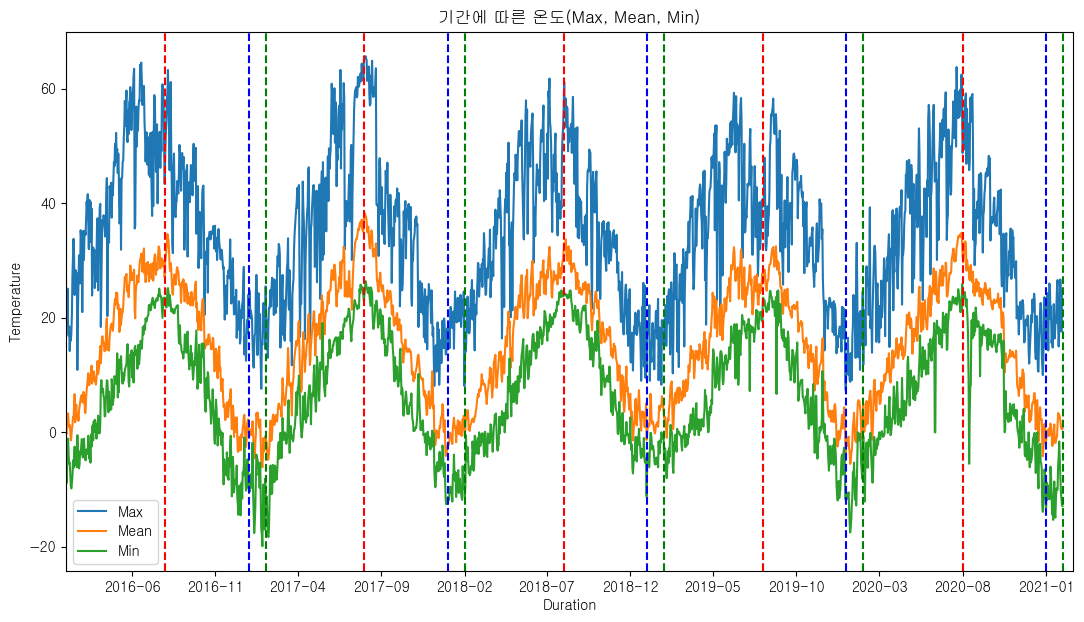

In [13]:
plt.figure(figsize=(13,7))
plt.title('기간에 따른 온도(Max, Mean, Min)')
plt.plot(daily_stats.index, daily_stats['max'], label='Max')
plt.plot(daily_stats.index, daily_stats['mean'], label='Mean')
plt.plot(daily_stats.index, daily_stats['min'], label='Min')
plt.xlabel('Duration')
plt.xticks()
plt.ylabel('Temperature')
plt.legend()

# Set x-axis ticks to be monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlim(daily_stats.index.min(), pd.Timestamp(year=2021, month=2, day=20))
for year in range(daily_stats.index.min().year, daily_stats.index.max().year + 1):
    plt.axvline(x=pd.Timestamp(year=year, month=8, day=1), color='red', linestyle='--')
    plt.axvline(x=pd.Timestamp(year=year, month=1, day=1), color='blue', linestyle='--')
    plt.axvline(x=pd.Timestamp(year=year, month=2, day=1), color='green', linestyle='--')

plt.show()

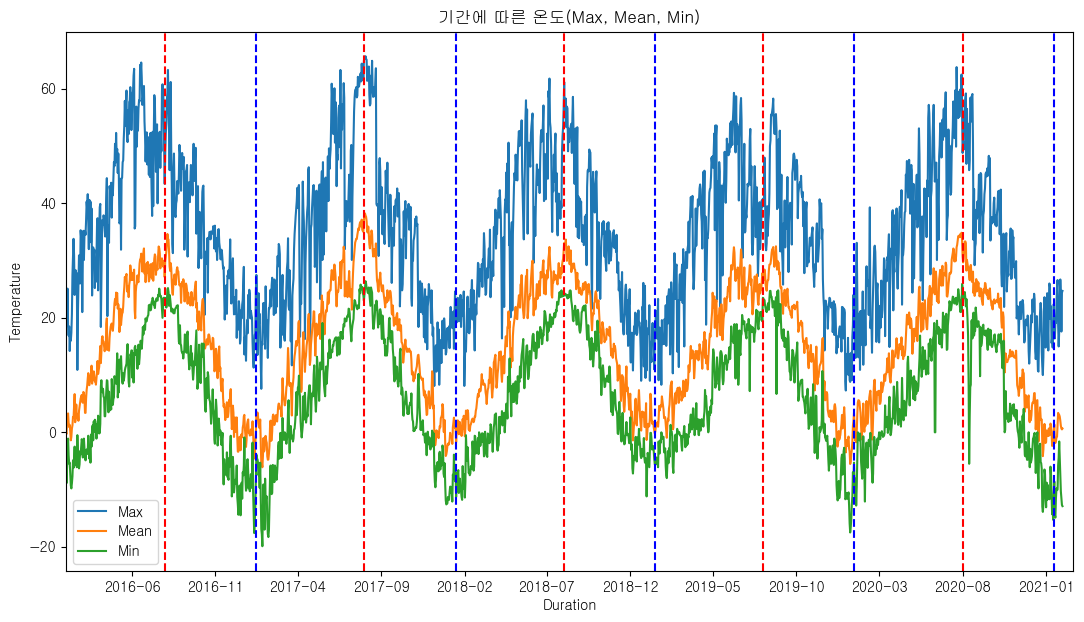

In [14]:
plt.figure(figsize=(13,7))
plt.title('기간에 따른 온도(Max, Mean, Min)')
plt.plot(daily_stats.index, daily_stats['max'], label='Max')
plt.plot(daily_stats.index, daily_stats['mean'], label='Mean')
plt.plot(daily_stats.index, daily_stats['min'], label='Min')
plt.xlabel('Duration')
plt.xticks()
plt.ylabel('Temperature')
plt.legend()

# Set x-axis ticks to be monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlim(daily_stats.index.min(), pd.Timestamp(year=2021, month=2, day=20))
for year in range(daily_stats.index.min().year, daily_stats.index.max().year + 1):
    plt.axvline(x=pd.Timestamp(year=year, month=8, day=1), color='red', linestyle='--')
    plt.axvline(x=pd.Timestamp(year=year, month=1, day=15), color='blue', linestyle='--')
    
plt.show()


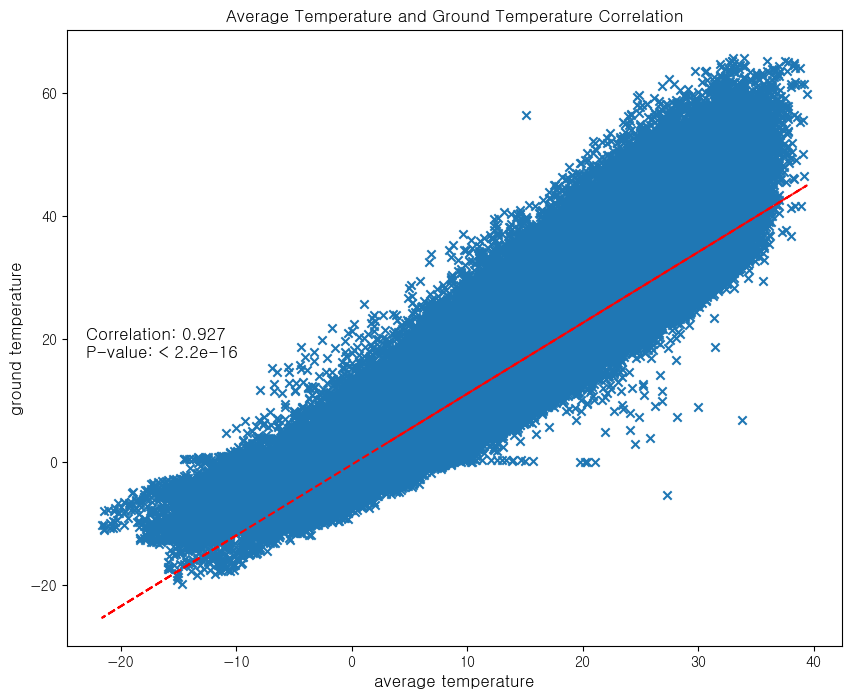

In [15]:
plt.figure(figsize=(10,8))
markers = 'x'

# 결측 제거
train_copy_cleaned = train_copy.dropna(subset=['ta', 'ts']).replace([np.inf, -np.inf], np.nan).dropna()

plt.scatter(x=train_copy_cleaned['ta'], y=train_copy_cleaned['ts'] ,marker=markers)
plt.title('Average Temperature and Ground Temperature Correlation', fontsize=12)
plt.xlabel('average temperature', fontsize=12)
plt.ylabel('ground temperature', fontsize=12)

# 양의 선형관계 라인 계산
slope, intercept = np.polyfit(train_copy_cleaned['ta'], train_copy_cleaned['ts'], deg=1)

# 선 추가
plt.plot(train_copy_cleaned['ta'], slope * train_copy_cleaned['ta'] + intercept, color='red', linestyle='--')

# 상관분석 검정 결과 출력
plt.text(-23, 20, f"Correlation: {0.927}", fontsize=12)
plt.text(-23, 17, f"P-value: {'< 2.2e-16'}", fontsize=12)

plt.show()

##### 데이터 셋 나누기

In [16]:
# check
print('spring')
print(train_copy[train_copy['season']==1]['spring'].unique())
print(train_copy[train_copy['season']==1]['summer'].unique())
print(train_copy[train_copy['season']==1]['autumn'].unique())
print(train_copy[train_copy['season']==1]['winter'].unique())
print('summer')
print(train_copy[train_copy['season']==2]['spring'].unique())
print(train_copy[train_copy['season']==2]['summer'].unique())
print(train_copy[train_copy['season']==2]['autumn'].unique())
print(train_copy[train_copy['season']==2]['winter'].unique())
print('autumn')
print(train_copy[train_copy['season']==3]['spring'].unique())
print(train_copy[train_copy['season']==3]['summer'].unique())
print(train_copy[train_copy['season']==3]['autumn'].unique())
print(train_copy[train_copy['season']==3]['winter'].unique())
print('winter')
print(train_copy[train_copy['season']==4]['spring'].unique())
print(train_copy[train_copy['season']==4]['summer'].unique())
print(train_copy[train_copy['season']==4]['autumn'].unique())
print(train_copy[train_copy['season']==4]['winter'].unique())

spring
[1]
[0]
[0]
[0]
summer
[0]
[1]
[0]
[0]
autumn
[0]
[0]
[1]
[0]
winter
[0]
[0]
[0]
[1]


##### version_1 사계절 나누기

In [17]:
spring = train_copy[train_copy['season']==1]
summer = train_copy[train_copy['season']==2]
autumn = train_copy[train_copy['season']==3]
winter = train_copy[train_copy['season']==4]

##### version_2 Up, Down 나누기

In [18]:
up = train_copy[(train_copy['season']==1)]
down = train_copy[train_copy['season']==2]

In [26]:
train_copy.rn.describe()

count    430473.000000
mean          0.153218
std           1.552163
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         623.500000
Name: rn, dtype: float64

In [22]:
print(f"1사분위수:{38*(1/3)}")
print(f"2/3지점{38*(2/3)}")

1사분위수:12.666666666666666
2/3지점25.333333333333332
